In [245]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from dataset import MetaDataset
from env import sr
from loss import MelMSE
from metadata.vcc import SanityMetadata, VCC2016TrainMetadata
from models import save_model, load_model
from models.vae import ToyVAE
from maml import reptile_train
from transform import log_stft, db_to_amp, from_gen_model_output
from dataset import read_audio, TaskDataset, InputData
from visualization import plot_spec
from vocoder import griffin_lim

In [247]:
# meta_data = SanityMetadata()
meta_data = VCC2016TrainMetadata()

In [248]:
dataset = MetaDataset(meta_data)
dataset.read_and_preprocess()
print('Data loaded', datetime.now())

Data loaded 2021-11-18 15:08:53.518819


In [262]:
device = torch.device('cpu')
model = ToyVAE()

criterion = nn.MSELoss()
# criterion = MelMSE(is_input_log_amp=False, n_mel=1024)
optimizer = optim.SGD(model.parameters(), lr=2e-4, weight_decay=0)


def train(trained_model, x, y, n_inner_loop=100, n_print_loss_period=None):
    trained_model.train()
    x = x.transpose(0, 1)
    # y = y.transpose(0, 1)
    x = x.to(device)
    y = y.to(device)
    for i in range(n_inner_loop):
        optimizer.zero_grad()
        out = trained_model(x)
        out = out.transpose(0, 1)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        if n_print_loss_period is None:
            if i % (n_inner_loop // 4) == 0:
                print(loss.item(), end=', ')
        else:
            if i % n_print_loss_period == 0:
                print('Pass', i, ': ', loss.item())

Source train aligned


Target train aligned


Pass 0 :  2000.384521484375
Pass 50 :  253.64512634277344
Pass 100 :  212.7272186279297
Pass 150 :  184.31118774414062
Pass 200 :  174.5894012451172
Pass 250 :  169.75946044921875
Pass 300 :  166.15480041503906
Pass 350 :  162.561279296875
Pass 400 :  158.92840576171875
Pass 450 :  155.24574279785156
Pass 500 :  151.646728515625
Pass 550 :  147.90353393554688
Pass 600 :  144.19580078125
Pass 650 :  140.615478515625
Pass 700 :  137.08082580566406
Pass 750 :  133.67764282226562
Pass 800 :  130.4265899658203
Pass 850 :  127.2787094116211
Pass 900 :  124.26962280273438
Pass 950 :  121.3828353881836
Pass 1000 :  118.78013610839844
Pass 1050 :  116.13554382324219
Pass 1100 :  113.727783203125
Pass 1150 :  111.51289367675781
Pass 1200 :  109.39657592773438
Pass 1250 :  107.5085678100586
Pass 1300 :  105.62715148925781
Pass 1350 :  103.85520935058594
Pass 1400 :  102.1819839477539
Pass 1450 :  100.68611145019531
Pass 1500 :  99.19595336914062
Pass 1550 :  97.90459442138672
Pass 1600 :  96.5280

Test estimate


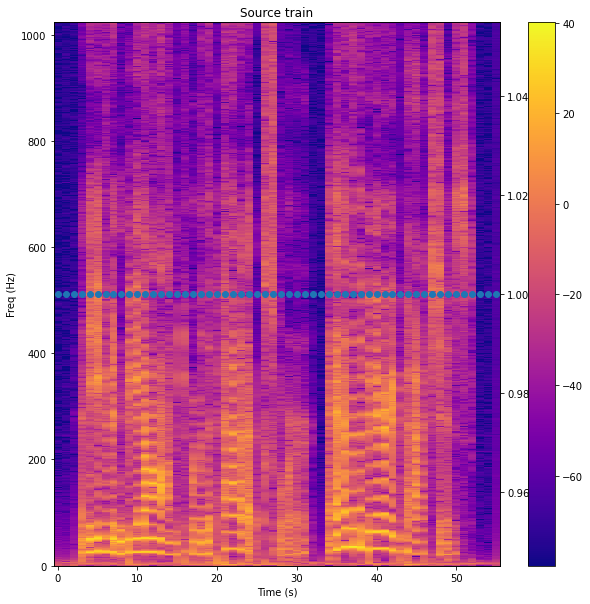

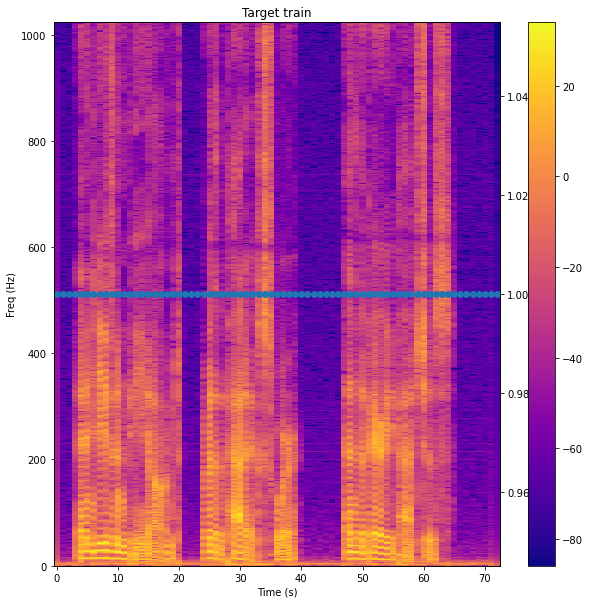

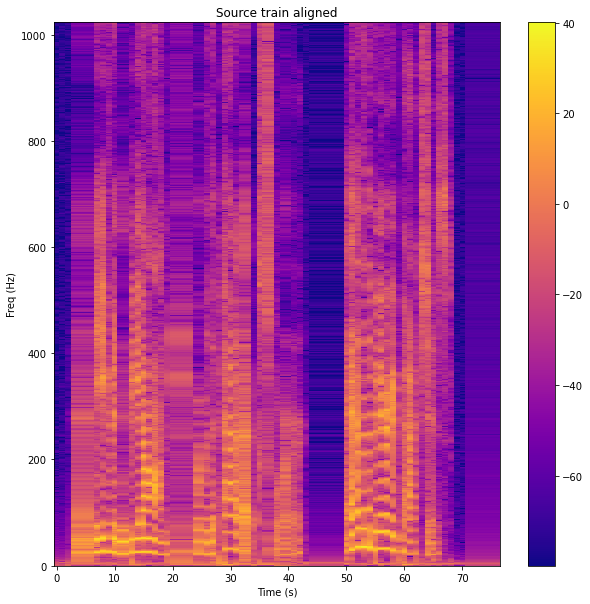

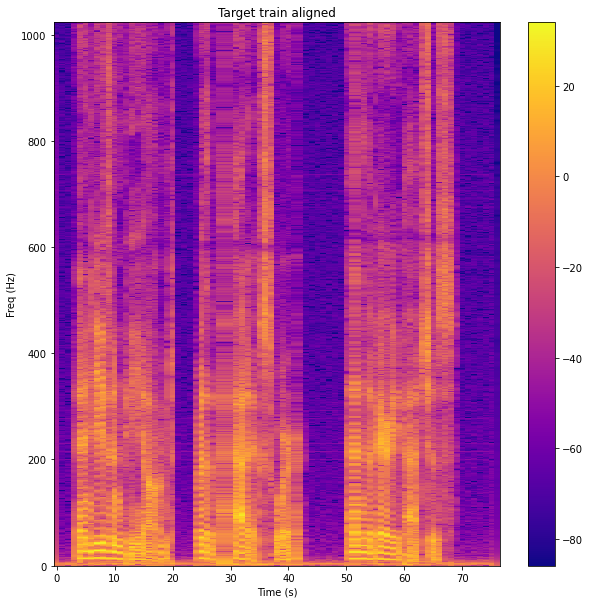

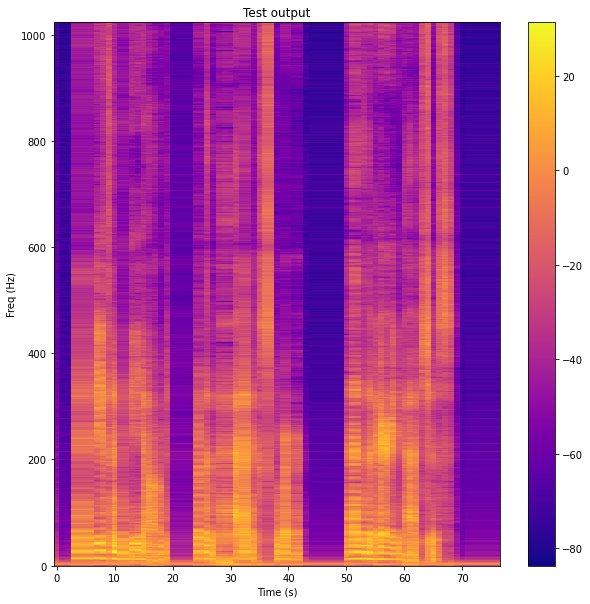

In [263]:
"""
This code block tests whether a model is "learnable" for a certain task
It simply fixes a single task and trains the model, and then it checks
model performance w.r.t. train set.
"""

def learnable_test(model, train_source_filename, train_target_filename,
                   vocode=False):
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)

    task_dat = TaskDataset(train_source_filename, train_target_filename)
    plot_spec(log_stft(task_dat.source.amp), title='Source train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    plot_spec(log_stft(task_dat.target.amp), title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)

    train_x, train_y = task_dat.get()
    plot_spec(train_x, title='Source train aligned', figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(train_x)),
              label='Source train aligned')

    plot_spec(train_y, title='Target train aligned',figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(train_y)),
                  label='Target train aligned')
    train(model, torch.from_numpy(train_x), torch.from_numpy(train_y),
          n_inner_loop=7000,n_print_loss_period=50) # TODO: tune this

    estimated = model(torch.from_numpy(train_x).transpose(0, 1))
    y = estimated.detach().numpy().T
    plot_spec(y, title='Test output',figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(y)), label='Test estimate')

learnable_test(model, meta_data.get(0, 0), meta_data.get(3, 0), vocode=True)

In [255]:
# Meta train

model = ToyVAE()

reptile_train(model, dataset, n_shot=None, n_iter_outer=500,
              outer_step_size=1e0, inner_train_func=train)
save_model('saved_models/temp.pt', model)

Iter 0: 1427.8272705078125, 1427.8272705078125, 1427.8272705078125, 1427.8272705078125, 
Iter 1: 1267.6866455078125, 1267.6866455078125, 1267.6866455078125, 1267.6866455078125, 
Iter 2: 1870.3782958984375, 1870.3782958984375, 1870.3782958984375, 1870.3782958984375, 
Iter 3: 1851.6790771484375, 1851.6790771484375, 1851.6790771484375, 1851.6790771484375, 
Iter 4: 1063.2413330078125, 1063.2413330078125, 1063.2413330078125, 1063.2413330078125, 
Iter 5: 1553.89306640625, 1553.89306640625, 1553.89306640625, 1553.89306640625, 
Iter 6: 1148.0382080078125, 1148.0382080078125, 1148.0382080078125, 1148.0382080078125, 
Iter 7: 1457.461669921875, 1457.461669921875, 1457.461669921875, 1457.461669921875, 
Iter 8: 1375.6163330078125, 1375.6163330078125, 1375.6163330078125, 1375.6163330078125, 
Iter 9: 1096.69775390625, 1096.69775390625, 1096.69775390625, 1096.69775390625, 
Iter 10: 2376.2021484375, 2376.2021484375, 2376.2021484375, 2376.2021484375, 
Iter 11: 1998.582275390625, 1998.582275390625, 1998.

In [259]:
# Second train after meta training

pretrained_model = load_model('saved_models/temp.pt', ToyVAE)


Source train


Target train


Source train aligned


Target train aligned


1662.64892578125, 1662.64892578125, 1662.64892578125, 1662.64892578125, 

Test source


Test estimate


Test source


Test estimate


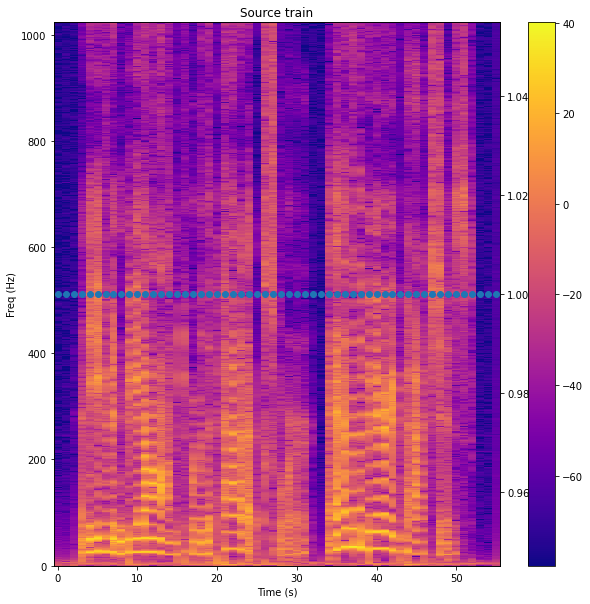

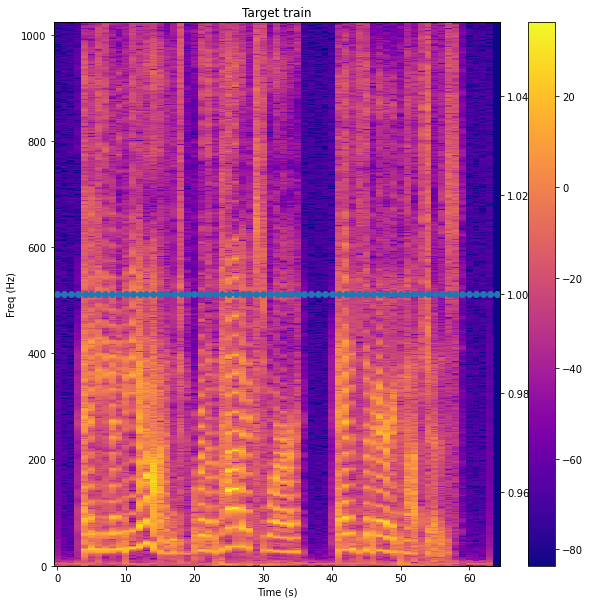

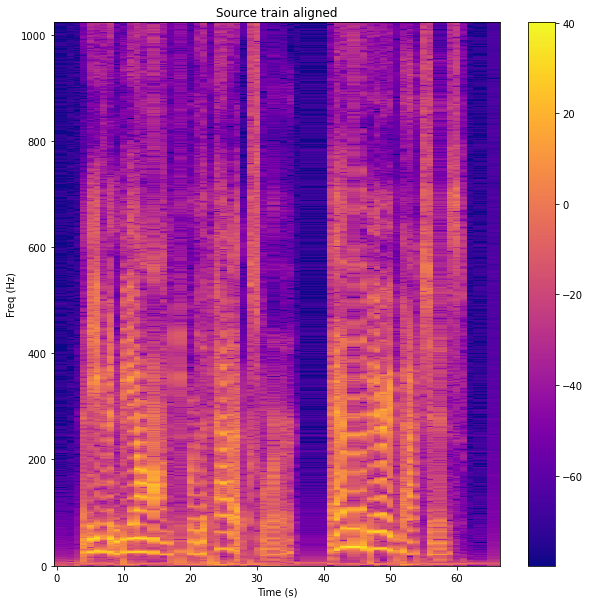

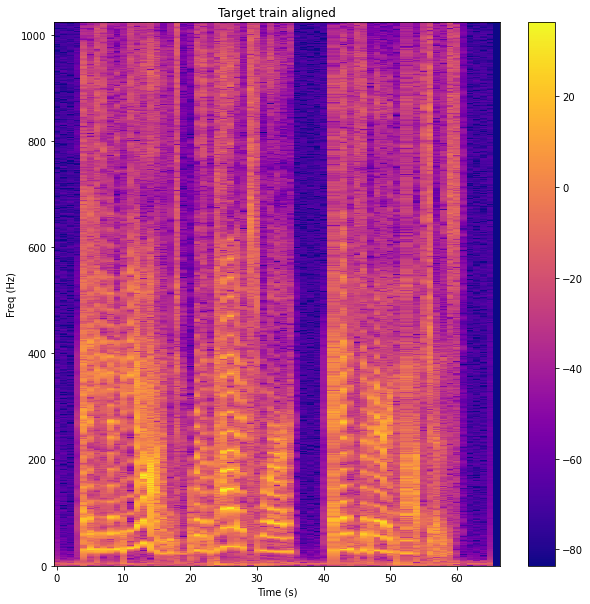

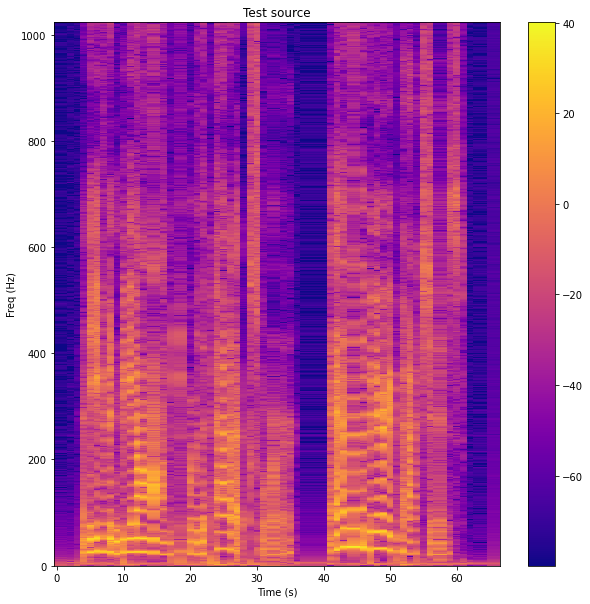

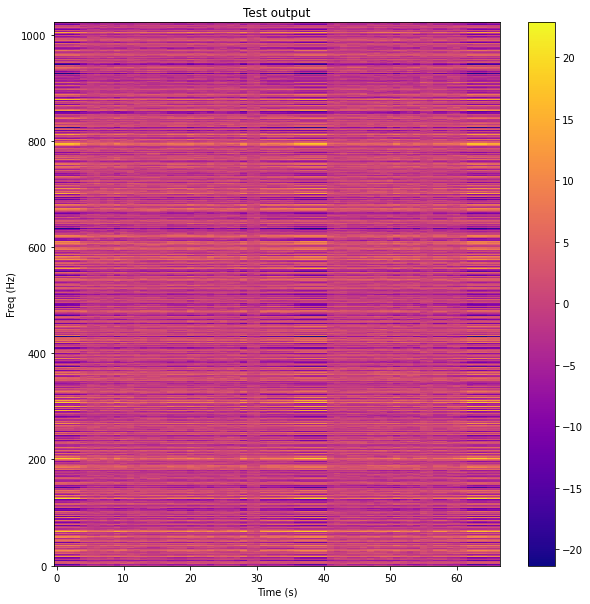

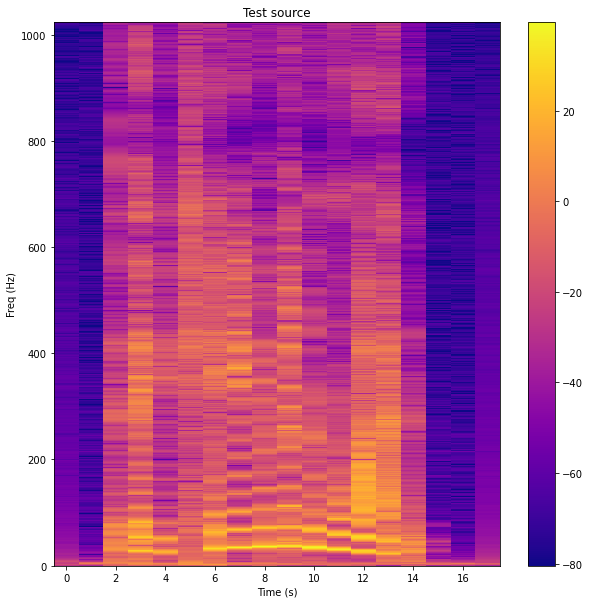

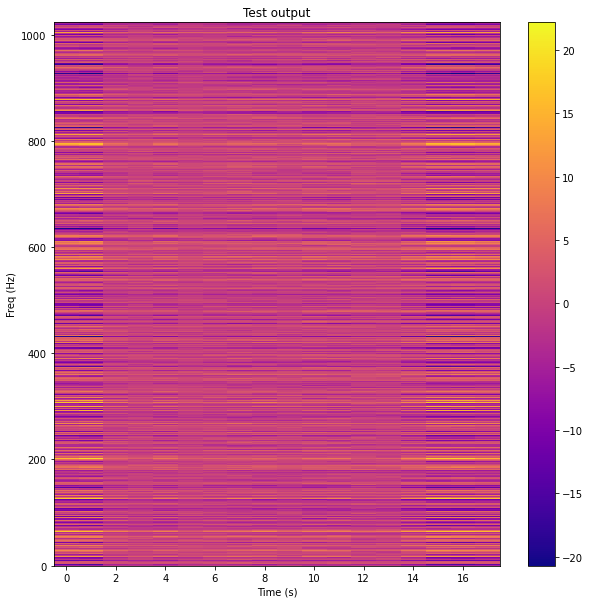

In [261]:


def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))


def test(model, train_source_filename, train_target_filename,
         test_input_filename, vocode=True):
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)

    task_dat = TaskDataset(train_source_filename, train_target_filename)
    input_dat = InputData(test_input_filename)
    plot_spec(log_stft(task_dat.source.amp), title='Source train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    sound(read_audio(train_source_filename), label='Source train')
    plot_spec(log_stft(task_dat.target.amp), title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)
    sound(read_audio(train_target_filename), label='Target train')

    train_x, train_y = task_dat.get()
    plot_spec(train_x, title='Source train aligned', figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(train_x)),
              label='Source train aligned')

    plot_spec(train_y, title='Target train aligned',figure_size=(10,10))
    if vocode:
        sound(griffin_lim(from_gen_model_output(train_y)),
              label='Target train aligned')

    train(model, torch.from_numpy(train_x), torch.from_numpy(train_y),
          n_inner_loop=5000)


    def test_sample(x):
        x = torch.from_numpy(x.T)
        estimated = model(x)
        y = estimated.detach().numpy().T
        plot_spec(x.T, title='Test source',
                  figure_size=(10,10))
        sound(read_audio(test_input_filename), label='Test source')
        plot_spec(y, title='Test output',figure_size=(10,10))
        if vocode:
            sound(griffin_lim(from_gen_model_output(y)), label='Test estimate')

    test_sample(train_x)

    test_sample(input_dat.get())


test(pretrained_model, meta_data.get(0, 0), meta_data.get(1, 0),
     meta_data.get(0, 1))

In [258]:
# test with actual samples
